# <font color='orange'>DIP Exercise 07</font>

In [2]:
# Force CPU usage
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Load packages
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.signal import wiener
from skimage.restoration import denoise_nl_means, estimate_sigma, richardson_lucy
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, Subtract, Activation, Flatten, Dense, Reshape

# Set random seed for reproducibility
np.random.seed(4)

As we already noticed in the second exercise, noise is always present in natural images. Those can arise from imaging system limitations or environmental factors and often distort information or complicate automated image processing. In some cases, noise removal is even mandatory to be able to extract information from images, such as in microscopy on molecule-level. In order to handle noisy images, we first need to understand the general underlying formation process of those images.


正如我们在第二个练习中已经注意到的，噪声总是存在于自然图像中。这些可能来自成像系统的限制或环境因素，并且经常扭曲信息或使自动图像处理复杂化。在某些情况下，噪声去除甚至是强制性的，以便能够从图像中提取信息，例如在分子水平的显微镜中。为了处理噪声图像，我们首先需要了解这些图像的一般底层形成过程。

<img src='question_sign.png' width=20px height=20px style="float:left;"> Give an equation, which describes the idealized image formation process including additive noise.<br>

给出一个方程，描述了包含加性噪声的理想图像形成过程

包含加性噪声的理想图像形成过程可以用以下方程表示：

\[ I_{\text{noisy}}(x, y) = I_{\text{clean}}(x, y) + N(x, y) \]

其中：
- \( I_{\text{noisy}}(x, y) \) 是观察到的带有噪声的图像的像素值。
- \( I_{\text{clean}}(x, y) \) 是没有噪声的理想图像的像素值。
- \( N(x, y) \) 是加性噪声的随机变量，表示在每个像素位置添加的噪声。

这个方程表示了观察到的图像是由理想图像和加性噪声组成的。在实际情况中，加性噪声通常是随机的，可能是来自于各种环境和设备的影响，如传感器噪声、电子噪声等。>

Additionaly, there are many different noise distributions, which each of them being applicable for different scenarios. In the following plot we show just a few, using parameters $a$ and $b$.

此外，还有许多不同的噪声分布，每一种都适用于不同的场景。在下面的图中，我们使用参数$a$和$b$展示了其中的几个。

## Noise Models

这段代码主要是为了展示不同的噪声分布以及它们的图形表示。以下是代码的主要解释：

- `x`: 一个从0到10的数组，以0.05为步长。
- `x_discrete`: 一个从0到10的整数数组，用于表示离散情况下的x值。
- `x_discrete_factorial`: 与`x_discrete`相对应的阶乘数组。
- `a` 和 `b`: 两个常数，用于定义不同的噪声分布。
- `noise_names`: 噪声分布的名称列表。
- `noise`: 一个字典，存储不同噪声分布的函数。

代码使用不同的参数和公式来创建四种不同的噪声分布（A、B、C、D）。然后，代码使用`matplotlib`库绘制了一个2x2的子图，每个子图显示了一种噪声分布的图形表示。噪声分布的具体形状和特征由不同的参数和函数来定义。

最后，代码使用`plt.show()`显示了所有的子图，以便于观察和比较不同噪声分布的图形。

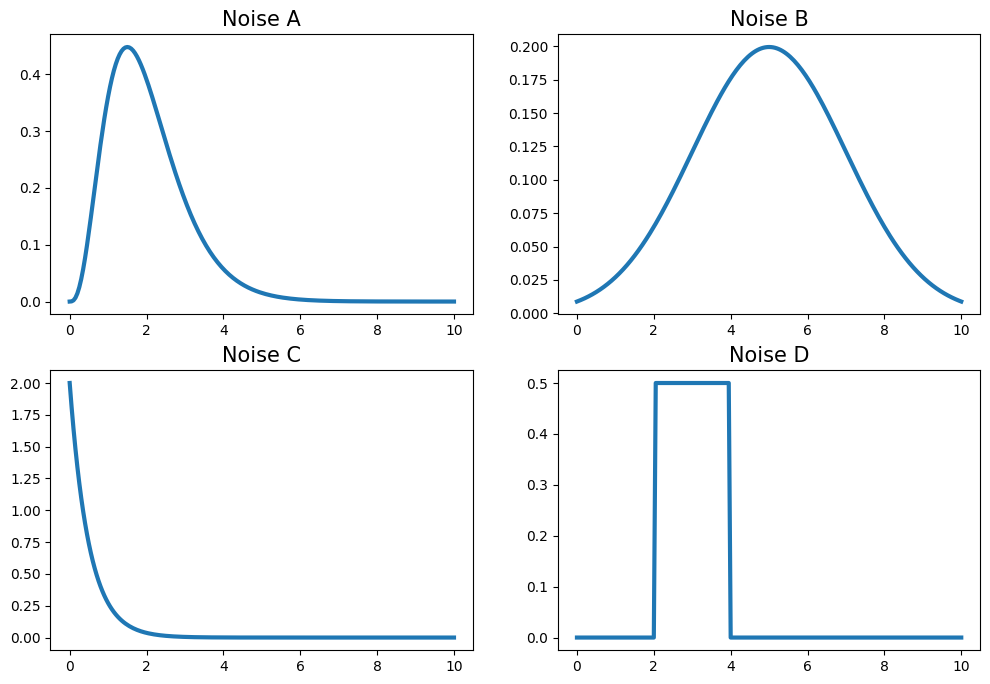

In [3]:
# Set parameters
x = np.array(np.arange(0, 10+0.05, 0.05))
x_discrete = np.array(np.arange(0, 11, 1))
x_discrete_factorial = np.array([np.math.factorial(n) for n in x_discrete])
a = 2
b = 4
noise_names = ['A', 'B', 'C', 'D']
noise = {}

# Create different noise distributions
noise['A'] = np.power(a, b)*np.power(x, b-1)*np.exp(-a*x)/np.math.factorial(b-1)
noise['B'] = np.exp(-(x-np.mean(x))**2/(2*a**2))/np.sqrt(2*np.pi*a**2)
noise['C'] = a*np.exp(-a*x)
noise['D'] = 1/(b-a)*(a<x)*(x<b)

# Plot each of the distributions
fig, axes = plt.subplots(2, 2, figsize=[12, 8])
ax = axes.flat
for i in np.arange(len(noise_names)):
    if noise_names[i] != 'F':
        ax[i].plot(x, noise[noise_names[i]], linewidth=3)
        ax[i].set_title('Noise '+noise_names[i], fontsize=15)
    else:
        ax[i].plot(x_discrete, noise[noise_names[i]], 'o-', linewidth=3)
        ax[i].set_title('Noise '+noise_names[i], fontsize=15)
plt.show()

<img src='question_sign.png' width=20px height=20px style="float:left;"> Name each of the noise distributions plotted above.<br>

A: Erlang (Gamma) noise | poisson noise| Rayleigh noise (Pretty similar and hard to distinquish)
厄朗(伽马)噪声|泊松噪声|瑞利噪声(非常相似，很难区分)

B: Gaussian noise

C: Exponential noise

D: Uniform noise


> 

## Noise Estimation

To be able to remove noise from images, we first have to determine which kind of noise is present in the image and what parameters are subject to it. For demonstration we create an example image showing a simple square and we add Gaussian noise with zero mean and unit standard deviation.

为了能够从图像中去除噪声，我们首先必须确定图像中存在哪种噪声以及受其影响的参数。为了演示，我们创建了一个显示简单正方形的示例图像，并添加了均值为零和单位标准差的高斯噪声。

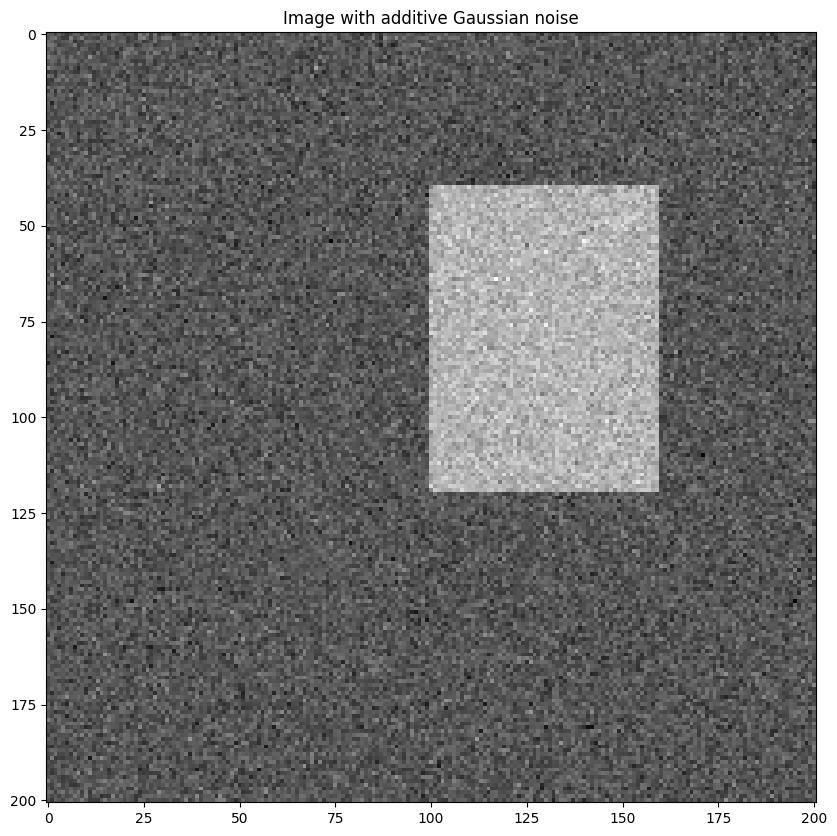

In [4]:
# Create a noisy image of a square
img_square = 50*np.ones([201, 201])
img_square[40:120, 100:160] = 55
gaussian_noise = np.random.randn(201, 201)
img_noise = img_square+gaussian_noise

# Plot the image
plt.figure(figsize=[10, 10])
plt.imshow(img_noise, cmap='gray')
plt.title('Image with additive Gaussian noise')
plt.show()

One straightforward way of examining the intensity distributions in images are histograms. Without noise, the histogram should have two distinct peaks for background and foreground (square), respectively. But since noise is present, the distributions should look somewhat different.

检查图像中强度分布的一种直接方法是直方图。在没有噪声的情况下，直方图的背景和前景(正方形)应该分别有两个不同的峰值。但由于存在噪声，分布应该看起来有些不同。

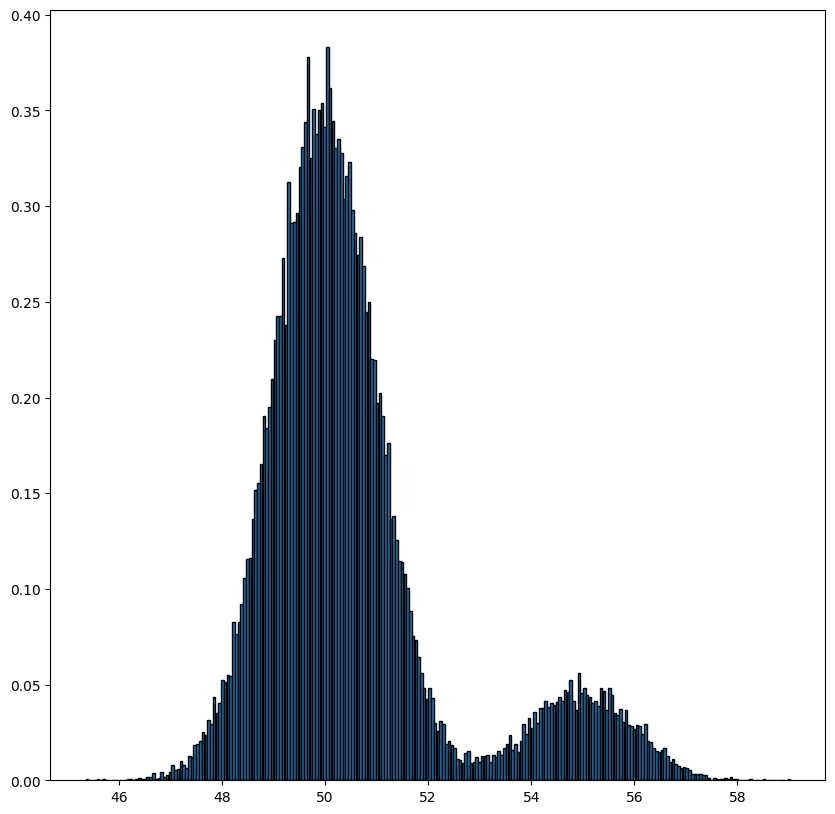

In [25]:
# Calculate the normalized histogram
hist, bins = np.histogram(img_noise, bins=255, density=True)
plt.figure(figsize=[10, 10])
plt.bar(bins[:-1], hist, width=0.05, edgecolor='k')
plt.show()

Just from the plot, we can tell, that the noise seems to follow a Gaussian distribution. Using the normalized histogram we can also extract mean and standard deviation from the whole image and try to estimate the noise parameters.

从图中我们可以看出，噪声似乎服从高斯分布。使用归一化直方图，我们还可以从整个图像中提取均值和标准差，并尝试估计噪声参数。

In [26]:
# Estimate the mean of the whole image
image_mean = np.sum(bins[:-1]*(hist/np.sum(hist)))
print('Image mean: {0}'.format(image_mean))

Image mean: 50.56757646997731


In [27]:
# Estimate the standard deviation of the whole image
image_std = np.sqrt(np.sum((bins[:-1]-image_mean)**2*(hist/np.sum(hist))))
print('Image standard deviation: {0}'.format(image_std))

Image standard deviation: 1.8968061302064503


Estimating these parameters directly from the normalized histogram of the whole image, however, also includes foreground intensities and object edges, which lead to completely distorted results. To estimate the actual noise distribution's parameters, one of the peaks, e.g., a region with plain texture, can be selected and mean as well as standard deviation can be extracted. Here we extract a patch from a background region.

然而，直接从整幅图像的归一化直方图中估计这些参数，还包括前景强度和物体边缘，导致结果完全扭曲。为了估计实际噪声分布的参数，可以选择其中一个峰值，例如纹理平坦的区域，提取平均值和标准差。在这里，我们从背景区域提取一个补丁。

这段代码用于绘制裁剪后的图像区域的亮度直方图

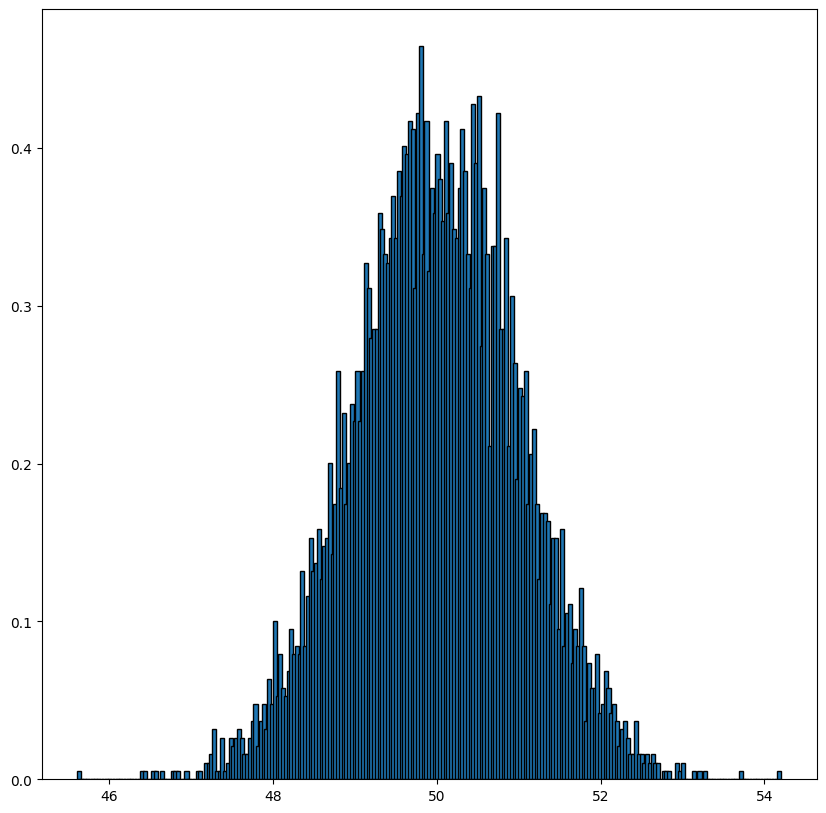

In [28]:
img_noise_crop = img_noise[:75,:75]
hist_crop, bins_crop = np.histogram(img_noise_crop, bins=255, density=True)
plt.figure(figsize=[10, 10])
plt.bar(bins_crop[:-1], hist_crop, width=0.05, edgecolor='k')
plt.show()

In [29]:
# Estimate the mean of the background region
estimated_mean = np.mean(img_noise_crop)
print('Estimated background mean: {0}'.format(estimated_mean))

Estimated background mean: 50.00439366293704


In [30]:
# Estimate the standard deviation of the background region
estimated_std = np.std(img_noise_crop)
print('Estimated background noise standard deviation: {0}'.format(estimated_std))

Estimated background noise standard deviation: 1.0019513102598532


In images, which don't show spacious plane regions, results might be inaccurate due to only little amount of data. To this end, one could average results from different small plane regions in the image or one could mathematically eliminate the effect of foreground intensities, as presented by [John Immakaer](https://www.deepdyve.com/lp/elsevier/fast-noise-variance-estimation-mOpgmPcOaA). He proposed a filter, which comprises a substraction of two different Laplacian filters and thus eliminates image edges, but preserves noise. Filtering the image with the proposed kernel leads to a noise estimation at every pixel, which can be averaged in a certain way, to obtain results for the whole image.


在没有显示宽敞平面区域的图像中，由于数据量很少，结果可能不准确。为此，可以对图像中不同小平面区域的结果进行平均，或者可以用数学方法消除前景强度的影响，如[John Immakaer](https://www.deepdyve.com/lp/elsevier/fast-noise-variance-estimation-mOpgmPcOaA)所示。他提出了一种滤波器，它包括两个不同的拉普拉斯滤波器的减法，从而消除了图像的边缘，但保留了噪声。用所提出的核对图像进行滤波，在每个像素处进行噪声估计，可以以一定的方式对噪声估计进行平均，从而得到对整个图像的结果。

In [31]:
# Filter kernel
noise_estimator = [[1, -2, 1], [-2, 4, -2], [1, -2, 1]]

# Filter the image
img_noise_estimate = ndimage.convolve(img_noise, noise_estimator, mode='constant', cval=0.0)

# Estimate the standard deviation
filtered_std = np.sqrt(np.sum(img_noise_estimate**2)/(36*img_noise_estimate.size))
print('Estimated noise standard deviation: {0}'.format(filtered_std))

Estimated noise standard deviation: 0.986224651816584


## Noise Removal

Lets consider some microscopy images and compare previous approaches to more sophisticated methods.

让我们考虑一些显微镜图像，并比较以前的方法和更复杂的方法。

这段代码加载HDF5文件中的图像数据，从中裁剪出一个指定大小的图像块，并对图像块进行归一化和幂次变换，最后显示图像块的一个切片。

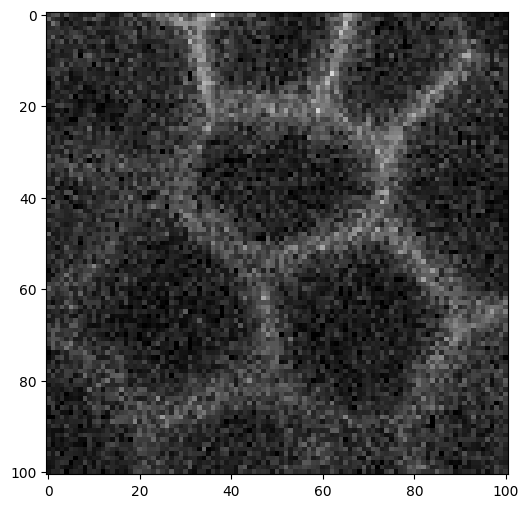

In [32]:
# Crop a patch at the upper right corner of the image
patch_size = [101, 101, 101]
with h5py.File(r'thaliana_membranes_48h.h5', 'r') as h5_handle:
    img = np.array(h5_handle['data/image'])
    img = np.transpose(img, axes=(2,1,0))
    
    # Crop the patch
    img_patch = img[:patch_size[0], img.shape[1]-patch_size[1]:img.shape[1], :patch_size[2]]
    img_patch = (img_patch-np.min(img_patch))/(np.max(img_patch)-np.min(img_patch))
    img_patch = np.power(img_patch, 0.75)

# Plot a sample slice
plt.figure(figsize=[6,6])
plt.imshow(img_patch[:, :, 0], cmap='gray')
plt.show()

First we again examine the intensity distribution by plotting the normalized histogram.

首先，我们通过绘制标准化直方图再次检查强度分布。

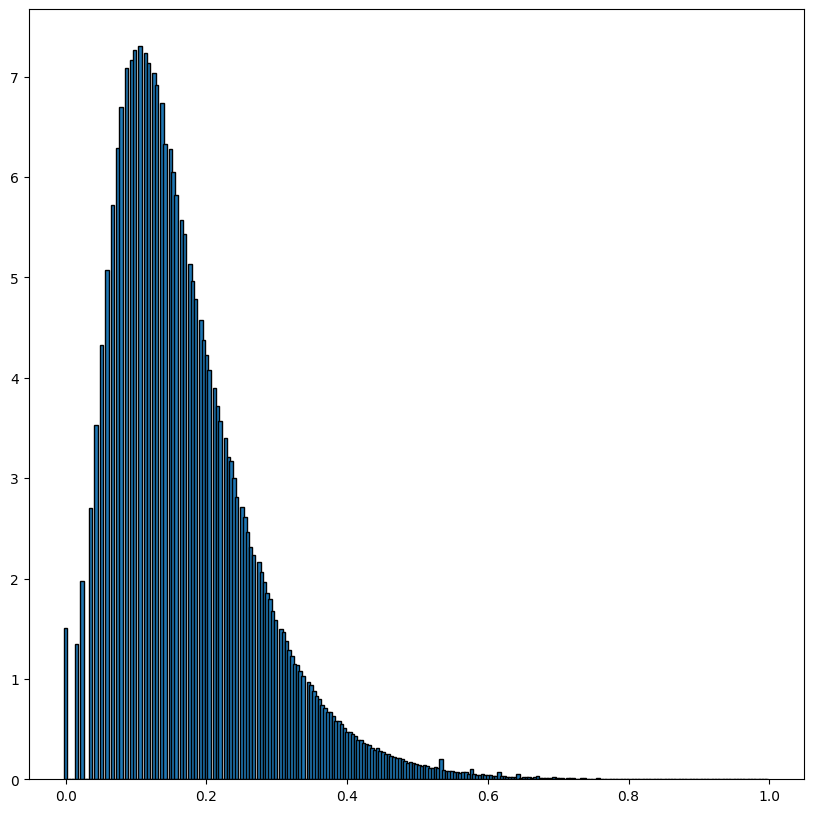

In [33]:
# Calculate the normalized histogram
hist_h5, bins_h5 = np.histogram(img_patch, bins=255, density=True)
plt.figure(figsize=[10, 10])
plt.bar(bins_h5[:-1], hist_h5, width=0.005, edgecolor='k')
plt.show()

<img src='question_sign.png' width=20px height=20px style="float:left;"> Which distribution can be chosen to model the intensity distribution shown in the histogram?<br>

可以选择哪种分布来模拟直方图中显示的强度分布?

The Erlang (Gamma), Poisson or Rayleight noise model

For this image, estimation of the noise distribution seems easy. For more complex cases, regardless of the underlying noise distribution, a more sophisticated approach is presented by the Non-Local Means (NLM) algorithm.

对于这幅图像，估计噪声分布似乎很容易。对于更复杂的情况，无论底层噪声分布如何，非局部均值(NLM)算法提出了一种更复杂的方法。

<img src='question_sign.png' width=20px height=20px style="float:left;"> Briefly describe the general idea of the Non-Local Means algorithm.<br>

For each smal region in a natural image, there are many othersimilar regions. This can be exploited to compare geometrical configurations ofa whole neighbourhod instead ofoperoting on a single puxel Thereore, each reqion is weighted by a decreasing entered exponentia unction and the findl result is a simlority-based weighting of all of the
neiqhbourhood pixel intensities.> 

对于自然图像中的每个小区域，都有许多其他类似的区域。这可以用来比较整个邻居的几何结构，而不是对单个像素进行操作。因此，每个区域都由一个递减的指数函数加权，最终结果是基于相似性的加权邻域像素强度。

Here we use a provided implementation of the Non-Local Means algorithm and compare it to the median filtered image.

这段代码对图像块应用了非局部均值（NLM）去噪和中值滤波算法，然后通过绘制比较图来显示每种去噪方法的效果

<Figure size 1600x800 with 0 Axes>

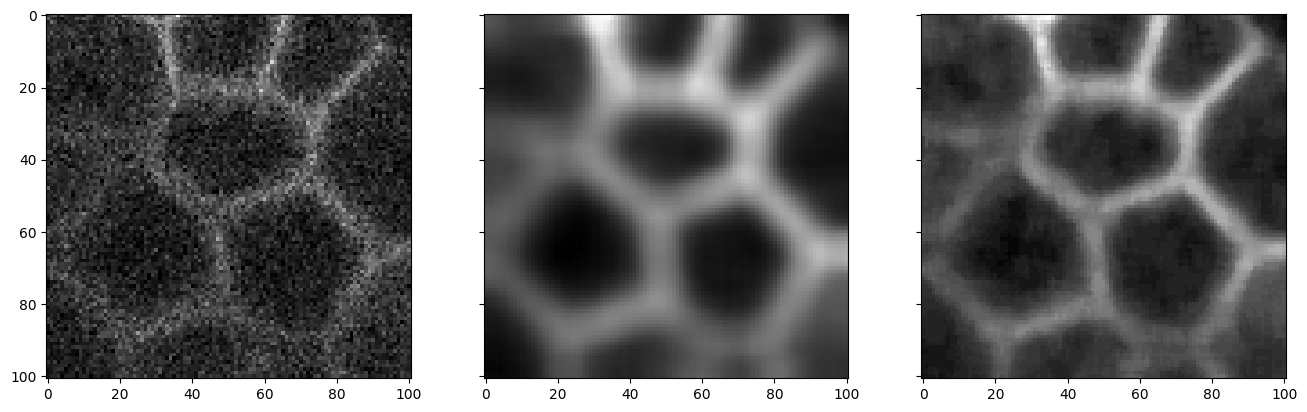

In [34]:
# Apply the NML algorithm
std_est = np.std(img_patch)
img_patch_nlm = denoise_nl_means(img_patch, h=std_est, sigma=std_est, fast_mode=True,\
                                 patch_size=5, patch_distance=5)

# Apply median filtering
img_patch_median = ndimage.median_filter(img_patch, size=[5,5,5])

# Plot the comparision between the NML algorithm and the median filtering
plt.figure(figsize=[16,8])
fig, axes = plt.subplots(1, 3, figsize=[16, 8], sharex=True, sharey=True)
ax = axes.flat
ax[0].imshow(img_patch[...,0], cmap='gray')
ax[1].imshow(img_patch_nlm[...,0], cmap='gray')
ax[2].imshow(img_patch_median[...,0], cmap='gray')
plt.show()

## Image deconvolution

Additionaly to the additive noise, there are also other factors distorting the image, such as the Point Spred Function (PSF).

除了附加噪声外，还有其他因素使图像失真，例如点扩散函数(PSF)。

<img src='question_sign.png' width=20px height=20px style="float:left;"> As we are working with microscopy images, briefly describe what's meant by the term Point Spread Function in this regard and how it can be used to enhance image quality.<br>

当我们使用显微镜图像时，简要地描述一下在这方面术语点扩展函数的含义以及如何使用它来提高图像质量

A Point Spread Function descrtbes the shae of an idealzed point imaged throuoh the opticadl system. As the iaht passes throuoh the aperture of the ootical system it gets difracted and forms an intererence potem which we call the point spread function. The image is then formed by the ovolution of this point spread function with every pointin the objert space. As a resul, the optical system causes an ideal point to be shown as a blury spot due to diftraction and interference of lioht. Deconvolving the image bythe system's PSF therefore results in a deblurred image.>

点扩展函数描述通过光学系统成像的理想点的比例。当它通过光学系统的孔径时，它会被分散，形成一个干涉函数，我们称之为点扩散函数。然后通过该点扩展函数与目标空间中的每个点的演化形成图像。因此，由于光的衍射和干涉，光学系统使理想点显示为模糊点。因此，通过系统的PSF对图像进行反卷积可以得到去模糊的图像。

<img src='question_sign.png' width=20px height=20px style="float:left;"> What's the name of the PSF's Fourier Transform?<br>

Optical Transfer Function (OTF)>

For demonstration purpposes we consider another image, which is corrupted by a simulated Gaussian PSF and additive Gaussian noise.

为了演示目的，我们考虑另一幅图像，它被模拟的高斯PSF和加性高斯噪声破坏。

该函数会生成一个8x8的黑白棋盘图像

In [35]:
def checkerboard(side_length=20):    
    # Generate a 8-by-8 checkerboard having squares in the size of side_length*side_length pixels
    
    board = np.zeros([side_length*8, side_length*8])
    for i in np.arange(8):
        
        i_left = i*side_length
        i_right = (i+1)*side_length
        
        if i%2==0:
            for j in np.arange(4):
                board[i_left:i_right, 2*j*side_length:(2*j+1)*side_length] = 1.0
        else:
            for j in np.arange(4):
                board[i_left:i_right, (2*j+1)*side_length:(2*j+2)*side_length] = 1.0           
                     
    return board

In [36]:
def gaussian_2D(side_length=5, sigma=2, mu=0):
    
    x, y = np.meshgrid(np.linspace(-1,1,side_length), np.linspace(-1,1,side_length))
    d = np.sqrt(x*x+y*y)
    g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
    g /= np.sum(g)
    
    return g

该代码段演示了对黑白棋盘图像应用点扩散函数进行模糊，并添加高斯噪声的过程，并比较了原始图像和受到影响的图像。

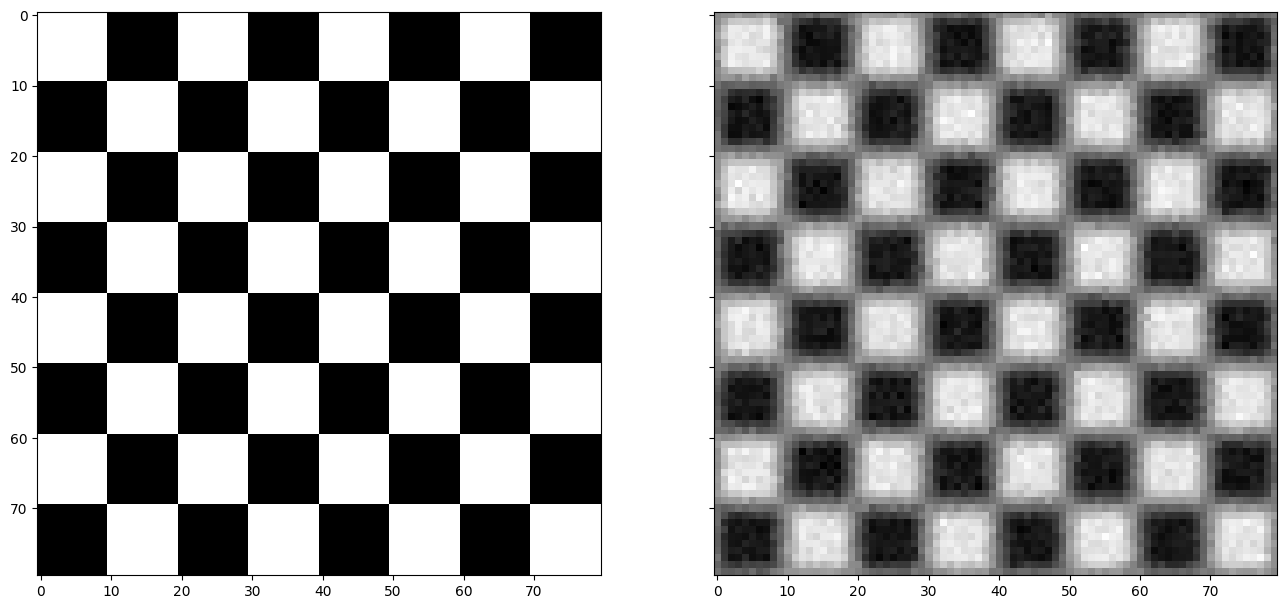

In [37]:
# Load the image and define the PSF
checkerboard_img = checkerboard(10)
applied_PSF = gaussian_2D(5, sigma=1, mu=0)

# Convolve with the PSF and add Gaussian noise
checkerboard_blurred = ndimage.convolve(checkerboard_img, applied_PSF, mode='wrap')
noise_var = 0.04
gaussian_noise = np.random.normal(0.0, noise_var, size=checkerboard_img.shape)
checkerboard_noisy = checkerboard_blurred + gaussian_noise

# Compare the distorted image with the original one
fig, axes = plt.subplots(1, 2, figsize=[16, 8], sharex=True, sharey=True)
ax = axes.flat
ax[0].imshow(checkerboard_img, cmap='gray')
ax[1].imshow(checkerboard_noisy, cmap='gray')
plt.show()

One approach taking account of both distortions is presented by the **Wiener filter**, which tries to estimate the unknown noise signal in the image. This requires knowledge about the PSF and the noise-to-signal ratio, which is either known from the imaging setup or can be estimated by further statistical analysis. The result is compared to the original distorted image.

一种考虑到这两种失真的方法是由维纳滤波器提出的，它试图估计图像中的未知噪声信号。这需要了解PSF和信噪比，这可以从成像设置中知道，也可以通过进一步的统计分析来估计。结果与原始失真图像进行了比较。

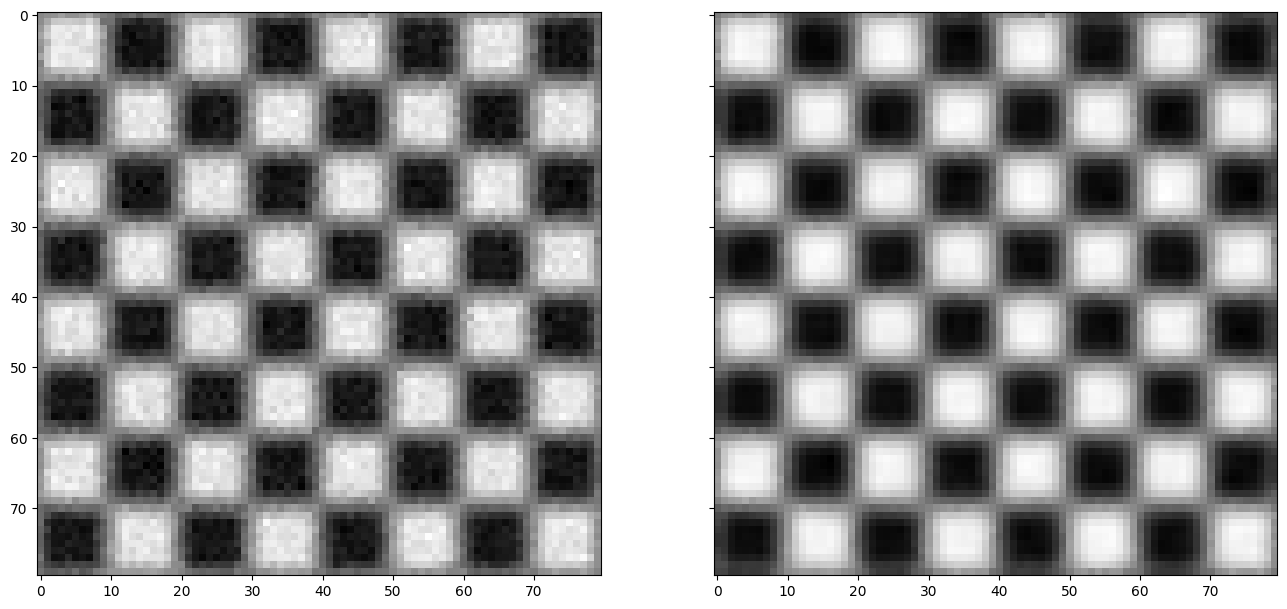

In [38]:
# Filter the image with the Wiener filter
checkerboard_wiener = wiener(checkerboard_noisy, 3)

# Plot the result of the Wiener filter
fig, axes = plt.subplots(1, 2, figsize=[16, 8], sharex=True, sharey=True)
ax = axes.flat
ax[0].imshow(checkerboard_noisy, cmap='gray')
ax[1].imshow(checkerboard_wiener, cmap='gray')
plt.show()

Another approach, which uses the PSF to reconstruct a deblurred image, is the iterative Lucy-Richardson approach.

另一种使用PSF来重建去模糊图像的方法是迭代Lucy-Richardson方法。

<img src='question_sign.png' width=20px height=20px style="float:left;"> Draw a general scheme for iterative deconvolution algorithms.<br>

<img src='微信截图_20230819163549.png' width=600px height=400px style="float:left;">>

The result of this approach is also compared to the original distorted image.

并将该方法的结果与原始失真图像进行了比较。

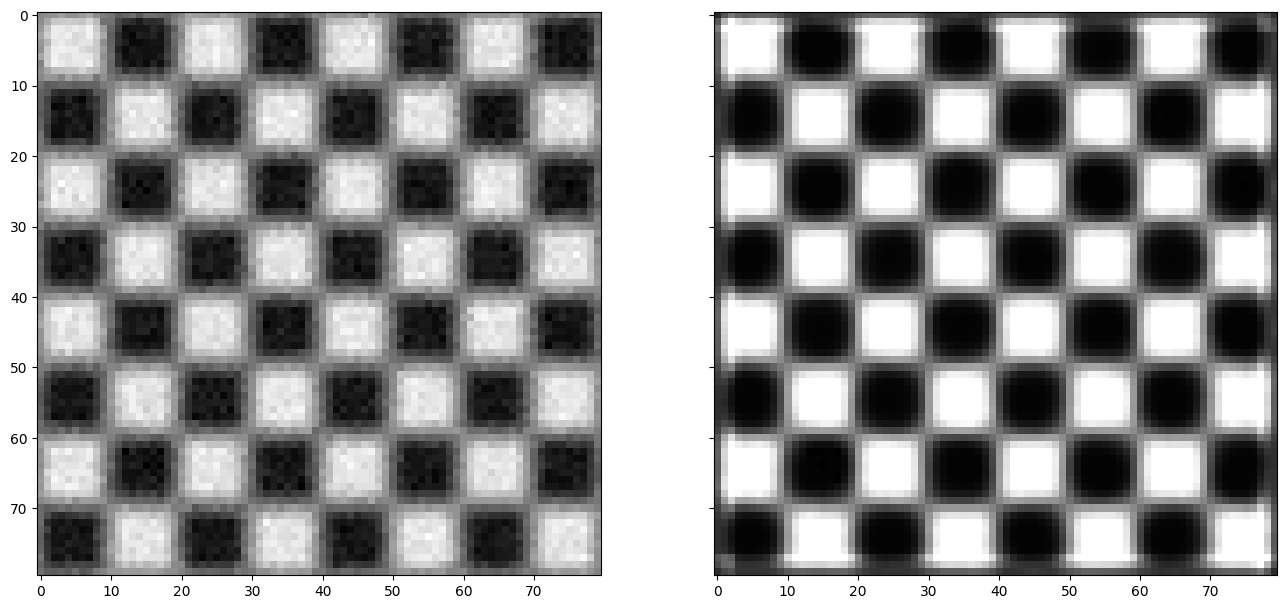

In [39]:
# Filter the image using Lucy-Richardson algorithm
checkerboard_LR = richardson_lucy(checkerboard_noisy, psf=applied_PSF, num_iter=3)

# Plot the result of Lucy-Richardson algorithm 
fig, axes = plt.subplots(1, 2, figsize=[16, 8], sharex=True, sharey=True)
ax = axes.flat
ax[0].imshow(checkerboard_noisy, cmap='gray')
ax[1].imshow(checkerboard_LR, cmap='gray')
plt.show()

## Noise Removal Network 噪声去除网络

Instead of using predefined handcrafted filters, we can also use deep learning to solve the task of image denoising. Since we need a lot of training data for deep learning approaches, we again consider the MNIST data set, comprising a large collection of handwritten digits.

我们也可以使用深度学习来解决图像去噪的任务，而不是使用预定义的手工过滤器。由于深度学习方法需要大量的训练数据，我们再次考虑MNIST数据集，它包含大量手写数字。

这段代码展示了加载 MNIST 数据集，将其拆分为训练集和测试集，并对图像数据进行噪声添加后的效果。展示了原始图像和受噪声影响的图像之间的对比。

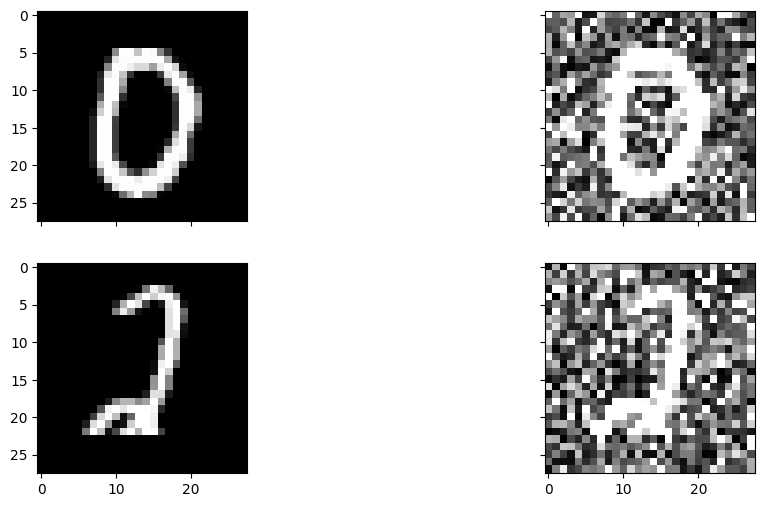

In [40]:
# Load the MNIST data set and split between train and test sets
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Use only a small part of the training set for acceleration of training
indices_train = np.random.choice(np.arange(len(x_train)), size=8000, replace=False)
x_train = x_train[indices_train]
indices_test = np.random.choice(np.arange(len(x_test)), size=1000, replace=False)
x_test = x_test[indices_test]

# Max normalization (data is already normalized otherwise)
x_train = x_train.astype('float')/x_train.max()
x_test = x_test.astype('float')/x_test.max()

# Input dimensions for the network
num_channels = 1
_, img_rows, img_cols = x_train.shape

# Reshape the training and test data
x_train = x_train.reshape([-1, img_rows, img_cols, num_channels])
x_test = x_test.reshape([-1, img_rows, img_cols, num_channels])

# Create noise which can be applied to training and test data
x_train_noisy = x_train+np.abs(np.random.normal(loc=0.0, scale=0.6, size=x_train.shape))
x_test_noisy = x_test+np.abs(np.random.normal(loc=0.0, scale=0.6, size=x_test.shape))

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

# Showcase of the data set
img_idx = np.random.choice(np.arange(len(x_train)), 2, replace=False)
fig, axes = plt.subplots(2,2, figsize=[12, 6], sharex=True, sharey=True)
ax = axes.flat
ax[0].imshow(x_train[img_idx[0],...,0], cmap='gray')
ax[1].imshow(x_train_noisy[img_idx[0],...,0], cmap='gray')
ax[2].imshow(x_train[img_idx[1],...,0], cmap='gray')
ax[3].imshow(x_train_noisy[img_idx[1],...,0], cmap='gray')
plt.show()

The network architecture only consists of a series of convolutional layers, each followed by a ReLu activation function and a dropout layer. Finally the input is added to the output of the convolution series, which encourages the network to learn the noise and to subsequently remove it from the image.

网络架构仅由一系列卷积层组成，每个层后面都有一个ReLu激活函数和一个dropout层。最后，输入被添加到卷积序列的输出中，这鼓励网络学习噪声并随后将其从图像中去除。

<img src='question_sign.png' width=20px height=20px style="float:left;"> What's your guess on the main purpose of a dropout layer?<br>

你认为dropout层的主要目的是什么?

The dropout layer randomly deactivates neurons during training and thus forces the network to not rely on specific neuron onections, but generalize beter to the task. Sincethis improves generalizability, the network is also less prone to overfitting. During test time the dropout is usually deactivated.> 

dropout层在训练过程中随机地使神经元失活，从而迫使网络不依赖于特定的神经元连接，而是更好地泛化到任务中。由于这提高了泛化性，网络也不太容易出现过拟合。在测试期间，dropout通常是停用的。

In [44]:
# Reset the current Keras graph
tf.keras.backend.clear_session()

# Force CPU usage, if you have trouble using the GPU
# Otherwise, comment this line out
tf.config.experimental.set_visible_devices([], 'GPU')

# Hyperparameters
batch_size = 50
num_epochs = 5

# Define the convolutional network
CNN_inputs = tf.keras.Input(shape=(img_rows, img_cols, num_channels))
conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(CNN_inputs)
dropout1 = tf.keras.layers.Dropout(rate=0.2)(conv1)
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(rate=0.2)(conv2)
conv3 = tf.keras.layers.Conv2D(filters=4, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(dropout2)
dropout3 = tf.keras.layers.Dropout(rate=0.2)(conv3)
conv4 = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(dropout3)
residual1 = tf.keras.layers.Subtract()([CNN_inputs, conv4])
CNN_outputs = tf.keras.layers.Activation('relu')(residual1)

# Instantiate the model
CNN_denoising = tf.keras.Model(inputs=CNN_inputs, outputs=CNN_outputs)

# Define optimizer and loss
CNN_denoising.compile(loss='mean_squared_error', optimizer='adam')

# Train the network
CNN_history = CNN_denoising.fit(x_train_noisy, x_train, batch_size=batch_size, epochs=num_epochs,
                                validation_split=0.2, shuffle=True)



Epoch 1/5
128/128 [==============================] - 3s 19ms/step - loss: 0.1273 - val_loss: 0.0195
Epoch 2/5
128/128 [==============================] - 2s 19ms/step - loss: 0.0486 - val_loss: 0.0126
Epoch 3/5
128/128 [==============================] - 3s 20ms/step - loss: 0.0407 - val_loss: 0.0112
Epoch 4/5
128/128 [==============================] - 2s 18ms/step - loss: 0.0341 - val_loss: 0.0102
Epoch 5/5
128/128 [==============================] - 2s 19ms/step - loss: 0.0293 - val_loss: 0.0096


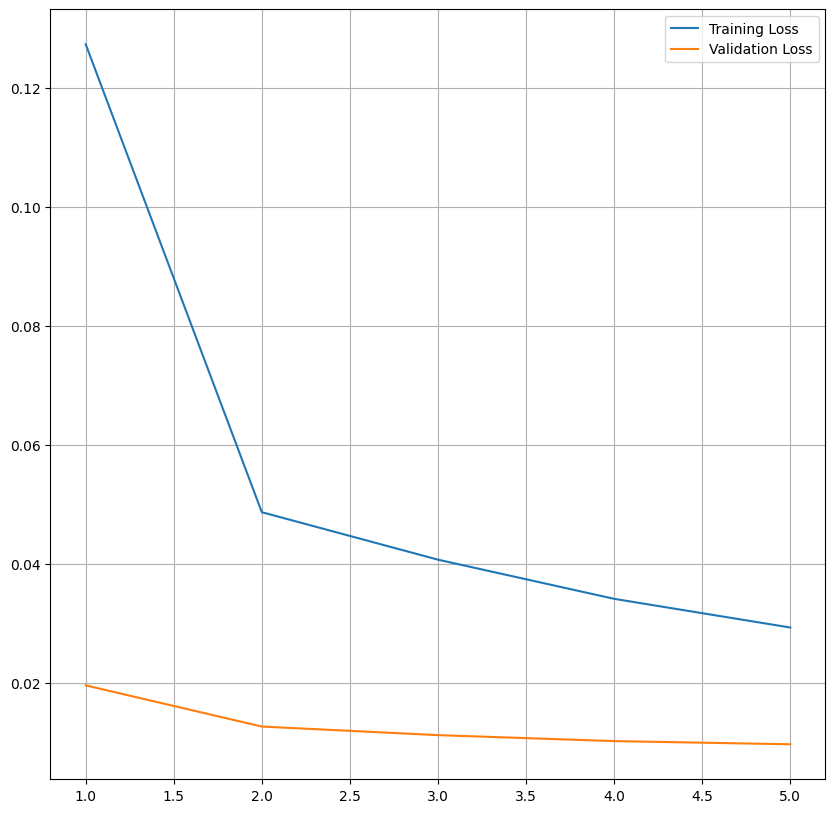

In [45]:
# Plot training & validation loss values
CNN_loss = CNN_history.history['loss']
CNN_val_loss = CNN_history.history['val_loss']

plt.figure(figsize=[10,10])
plt.plot(np.arange(1, num_epochs+1), CNN_loss)
plt.plot(np.arange(1, num_epochs+1), CNN_val_loss)
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

32/32 [==============================] - 0s 3ms/step


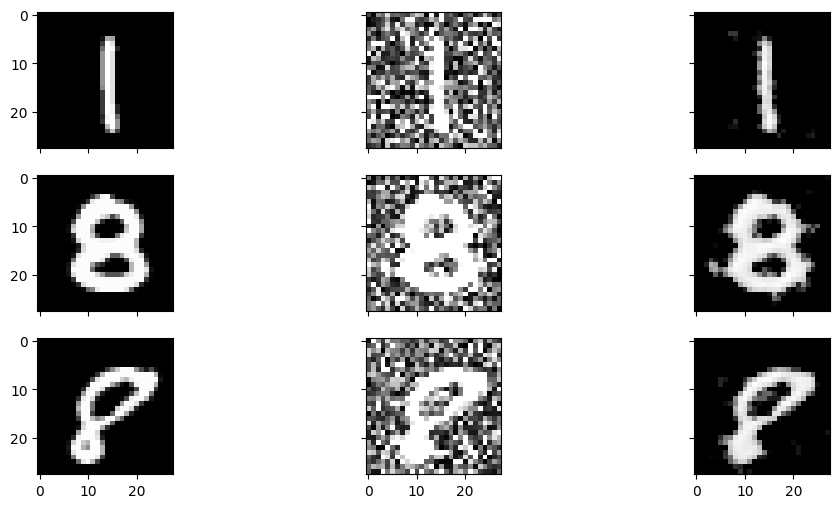

In [47]:
# Predict results of the test data
CNN_pred = CNN_denoising.predict(x_test_noisy)

# Plot the results
img_idx = np.random.choice(np.arange(len(CNN_pred)), 3, replace=False)
fig, axes = plt.subplots(3,3, figsize=[12, 6], sharex=True, sharey=True)
ax = axes.flat
ax[0].imshow(x_test[img_idx[0],...,0], cmap='gray')
ax[1].imshow(x_test_noisy[img_idx[0],...,0], cmap='gray')
ax[2].imshow(CNN_pred[img_idx[0],...,0], cmap='gray')
ax[3].imshow(x_test[img_idx[1],...,0], cmap='gray')
ax[4].imshow(x_test_noisy[img_idx[1],...,0], cmap='gray')
ax[5].imshow(CNN_pred[img_idx[1],...,0], cmap='gray')
ax[6].imshow(x_test[img_idx[2],...,0], cmap='gray')
ax[7].imshow(x_test_noisy[img_idx[2],...,0], cmap='gray')
ax[8].imshow(CNN_pred[img_idx[2],...,0], cmap='gray')
plt.show()

## Autoencoder

Instead of modeling the noise, some approaches aim to find a general low-dimensional description of the image and only based on these parameters reconstruct the whole image. In deep learning these approaches are called *Autoencoder*. The underlying architecture uses various techniques to lower the dimensionality and number of parameters up to a very compact feature description, the so-called latent space or the network's bottleneck. Descriptors in the bottleneck are then used to again reconstruct the whole image.

有些方法不是对噪声进行建模，而是寻找图像的一般低维描述，并仅基于这些参数重建整个图像。在深度学习中，这些方法被称为“自动编码器”。底层架构使用各种技术来降低维度和参数数量，直到非常紧凑的特征描述，即所谓的潜在空间或网络瓶颈。然后使用瓶颈中的描述符再次重建整个图像。

<img src='question_sign.png' width=20px height=20px style="float:left;"> Why should the bottleneck of an autoencoder in general be smaller than the input and ouput sizes?<br>

为什么自动编码器的瓶颈通常应该小于输入和输出大小?

自动编码器（Autoencoder）是一种无监督学习算法，用于学习数据的有效表示，通常用于降维、特征提取和图像去噪等任务。自动编码器包括编码器（Encoder）和解码器（Decoder）两部分，其中编码器将输入数据映射到低维的瓶颈表示，解码器将瓶颈表示映射回原始输入的重建。

瓶颈（Bottleneck）是指自动编码器中的编码层，它的维度决定了数据的压缩表示。通常情况下，瓶颈维度小于输入和输出的维度是有好处的，这是因为：

1. **特征提取和压缩：** 较小的瓶颈维度可以迫使模型学习数据的更抽象和紧凑的表示。这有助于自动编码器捕获数据中的重要特征，从而更好地进行特征提取和压缩。

2. **减少过拟合：** 较小的瓶颈维度限制了自动编码器的容量，从而减少了过拟合的风险。过大的模型可能会过于拟合训练数据，导致在新数据上表现不佳。

3. **降低噪声和冗余：** 较小的瓶颈维度有助于去除输入数据中的噪声和冗余信息。模型被迫提取对重构有用的信息，而不是简单地将噪声和冗余信息传递到解码器。

4. **更高的泛化能力：** 通过强制模型在瓶颈中学习最重要的特征，它可能更有可能在未见过的数据上表现良好，因为它学习到了数据的更通用表示。

总之，自动编码器的瓶颈通常应该小于输入和输出大小，以便实现更好的特征提取、降维和去噪效果，并降低过拟合的风险。然而，适当的瓶颈维度大小可能取决于具体的任务和数据集。

> 

To start, each $28\times28$ image is reduced to only a few descriptors and then used to reconstruct the whole image.

首先，每个$28\times28$图像被简化为只有几个描述符，然后用于重建整个图像。

简单的卷积自动编码器（Convolutional Autoencoder）

In [48]:
# Reset the current Keras graph
tf.keras.backend.clear_session()

# Force CPU usage, if you have trouble using the GPU
# Otherwise, comment this line out
tf.config.experimental.set_visible_devices([], 'GPU')

# Hyperparameters
batch_size = 50
num_epochs = 5
latent_dimension = 98

# First build the Encoder Model
img_inputs = Input(shape=(img_rows, img_cols, num_channels))
conv_1 = Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(img_inputs)
conv_2 = Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(conv_1)

# Generate the latent vector
flattened = Flatten()(conv_2)
latent = Dense(units=latent_dimension)(flattened)

# Build the Decoder Model
dense_1 = Reshape((7, 7, 2))(latent)

conv_3 = Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(dense_1)
conv_4 = Conv2DTranspose(filters=16, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(conv_3)

img_outputs = Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid')(conv_4)

# Instantiate the Autoencoder Model
autoencoder = tf.keras.Model(inputs=img_inputs, outputs=img_outputs)

# Define optimizor and loss
autoencoder.compile(loss='mean_squared_error', optimizer='adam')

# Train the network
autoencoder_history = autoencoder.fit(x=x_train_noisy, y=x_train, batch_size=batch_size, epochs=num_epochs,
                                      validation_split=0.2, shuffle=True)

Epoch 1/5
128/128 [==============================] - 2s 13ms/step - loss: 0.0843 - val_loss: 0.0654
Epoch 2/5
128/128 [==============================] - 2s 12ms/step - loss: 0.0548 - val_loss: 0.0426
Epoch 3/5
128/128 [==============================] - 2s 12ms/step - loss: 0.0317 - val_loss: 0.0260
Epoch 4/5
128/128 [==============================] - 2s 12ms/step - loss: 0.0233 - val_loss: 0.0215
Epoch 5/5
128/128 [==============================] - 2s 12ms/step - loss: 0.0198 - val_loss: 0.0191


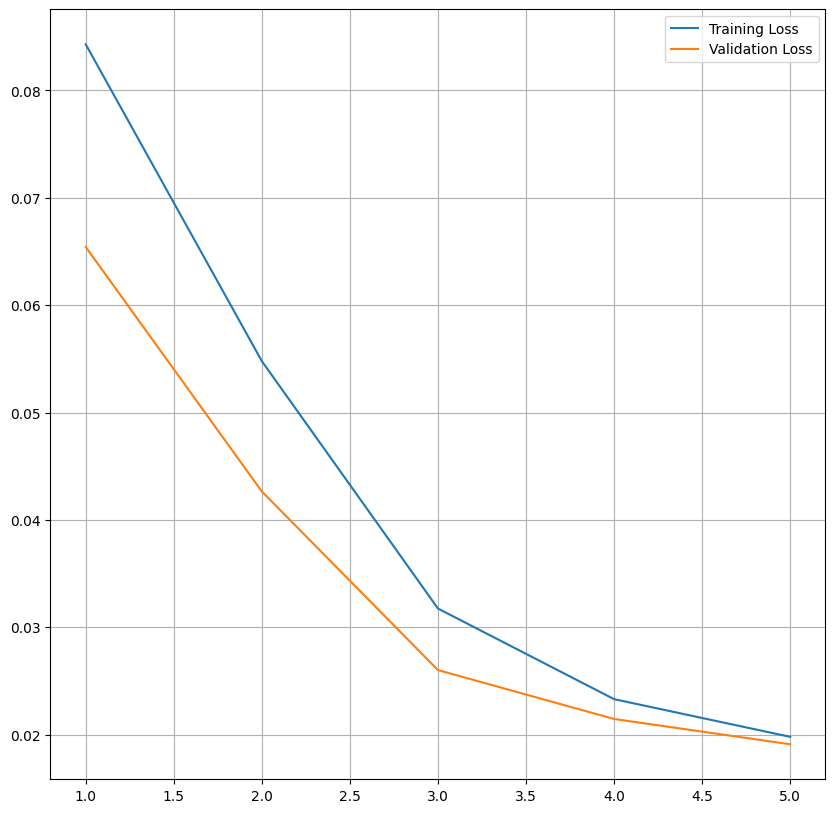

In [49]:
# Plot training & validation loss values
autoencoder_loss = autoencoder_history.history['loss']
autoencoder_val_loss = autoencoder_history.history['val_loss']

plt.figure(figsize=[10,10])
plt.plot(np.arange(1, num_epochs+1), autoencoder_loss)
plt.plot(np.arange(1, num_epochs+1), autoencoder_val_loss)
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

32/32 [==============================] - 0s 4ms/step


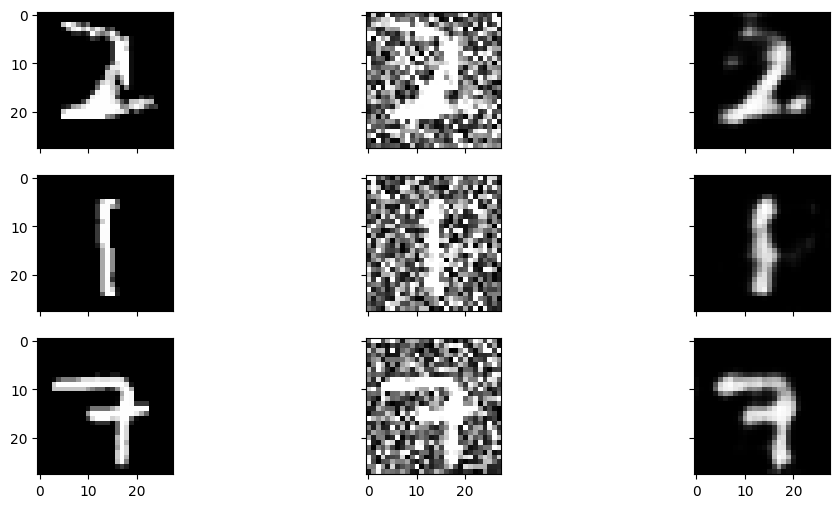

In [50]:
# Predict results of the test data
autoencoder_pred = autoencoder.predict(x_test_noisy)

# Plot the results
img_idx = np.random.choice(np.arange(len(CNN_pred)), 3, replace=False)
fig, axes = plt.subplots(3,3, figsize=[12, 6], sharex=True, sharey=True)
ax = axes.flat
ax[0].imshow(x_test[img_idx[0],...,0], cmap='gray')
ax[1].imshow(x_test_noisy[img_idx[0],...,0], cmap='gray')
ax[2].imshow(autoencoder_pred[img_idx[0],...,0], cmap='gray')
ax[3].imshow(x_test[img_idx[1],...,0], cmap='gray')
ax[4].imshow(x_test_noisy[img_idx[1],...,0], cmap='gray')
ax[5].imshow(autoencoder_pred[img_idx[1],...,0], cmap='gray')
ax[6].imshow(x_test[img_idx[2],...,0], cmap='gray')
ax[7].imshow(x_test_noisy[img_idx[2],...,0], cmap='gray')
ax[8].imshow(autoencoder_pred[img_idx[2],...,0], cmap='gray')
plt.show()